# Spin Configuration Generator

In [46]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os

### Loading Datasets

You can load different datasets by changing the dataset path for testing, trainging, and benchmarking

In [47]:
L = 32

In [48]:
# Set these variables to the appropriate directory paths

train_dir = '../data/{}-{}/temp_class/train/'.format(L,L)

# Set these variables to the appropriate directory paths
benchmark_dir = '../data/{}-{}/temp_class/test/'.format(L,L)

In [49]:
# data transforms
dset_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])

#create datasets using ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=dset_transform)
# test_data = datasets.ImageFolder(test_dir, transform=dset_transform)
benchmark_data = datasets.ImageFolder(benchmark_dir, transform=dset_transform)

batch_size = 64
# create dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [50]:
num_classes = len(train_data.classes)

### Helper functions

Thanks to Teal Witter for code for these helper functions https://github.com/rtealwitter/dl-demos/blob/b537a5dd94953ea656a2140227af78f67c042540/demo11-conditional-gan.ipynb

In [51]:
def normalize_generator_output(x):
    #convert to binary data
    x[x>=0.5] = 1
    x[x<0.5] = 0
    return x

In [52]:
def to_onehot(x, num_classes=2):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c


In [53]:
def get_sample_image(G, DEVICE, n_noise=100):
    img = np.zeros([L*num_classes, L*num_classes])
    for j in range(num_classes):
        c = torch.zeros([num_classes, num_classes]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(num_classes, n_noise).to(DEVICE)
        y_hat = G(z,c).view(num_classes, L, L)
        y_hat = normalize_generator_output(y_hat)
        result = y_hat.cpu().data.numpy()
        img[j*L:(j+1)*L] = np.concatenate([x for x in result], axis=-1)
    return img

In [54]:
input_size = [L,L]
hidden_layers = 10
layer_size = 256

## Architecture

Define the architecture of the generator and discriminator

In [55]:
def linear_block(layer_size, num_layers):
    layers = []
    for i in range(num_layers):
        layers.append(nn.Linear(layer_size, layer_size))
        layers.append(nn.LeakyReLU())
    return layers

In [56]:
class Generator(nn.Module):
    def __init__(self, image_dim, hidden_layers, layer_size, num_classes, input_size=100):
        super(Generator, self).__init__()
        self.image_size = np.prod(image_dim)
        self.input_layer = [nn.Linear(input_size + num_classes, layer_size)]
        self.hidden_layers = linear_block(layer_size, hidden_layers)
        self.output_layer = [nn.Linear(layer_size, self.image_size), nn.Tanh()]
        self.model = nn.Sequential(*self.input_layer, *self.hidden_layers, *self.output_layer)

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat([x, c], dim=1)
        return self.model(v)


In [57]:
class Discriminator(nn.Module):
    def __init__(self, image_dim, hidden_layers, layer_size, num_classes):
        super(Discriminator, self).__init__()
        self.image_size = np.prod(image_dim)
        self.input_layer = [nn.Linear(self.image_size + num_classes, layer_size)]
        self.hidden_layers = linear_block(layer_size, hidden_layers)
        self.output_layer = [nn.Linear(layer_size, 1), nn.Sigmoid()]
        self.model = nn.Sequential(*self.input_layer, *self.hidden_layers, *self.output_layer)

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat([x, c], dim=1)
        return self.model(v)

## Setup and Training

In [58]:
MODEL_PATH = './models/{}-{}-GAN/'.format(L,L)
SAMPLE_PATH = '../generated_samples/{}-{}-GAN/'.format(L,L)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator(input_size, hidden_layers, layer_size, num_classes).to(DEVICE)
G = Generator(input_size, hidden_layers, layer_size, num_classes).to(DEVICE)

max_epoch = 30
step = 0
n_noise = 100 # noise dimension

criterion = nn.BCELoss()
D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


# We will denote real images as 1s and fake images as 0s
# This is why we needed to drop the last batch of the data loader
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake

In [59]:
if not os.path.exists(SAMPLE_PATH):
    os.makedirs(SAMPLE_PATH)

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

for epoch in range(max_epoch):
    for i, (images, labels) in enumerate(train_loader):
        # Train Discriminator
        x = images.to(DEVICE)
        y = labels.view(batch_size, 1) # add singleton dimension so batch_size x 1
        y = to_onehot(y, num_classes=num_classes).to(DEVICE)

        x_outputs = D(x, y)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y)
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y)
        G_loss = -1 * criterion(z_outputs, D_fakes)

        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if step % 100 == 0:
            print('Epoch: {}, Step: {}, D_loss: {}, G_loss: {}'.format(epoch, step, D_loss.item(), G_loss.item()))
            
        if step % 500 == 0:
            G.eval()
            img = get_sample_image(G, DEVICE, n_noise)
            plt.imsave(SAMPLE_PATH + 'sample-{}-{}.png'.format(epoch, step), img, cmap='gray')
            G.train()

        step += 1


Epoch: 0, Step: 0, D_loss: 1.3865723609924316, G_loss: -0.6802883148193359
Epoch: 3, Step: 100, D_loss: 1.3300395011901855, G_loss: -0.5295279622077942
Epoch: 6, Step: 200, D_loss: 1.6028714179992676, G_loss: -0.7912464737892151
Epoch: 9, Step: 300, D_loss: 1.350998878479004, G_loss: -0.5542240142822266
Epoch: 12, Step: 400, D_loss: 1.367965817451477, G_loss: -0.6836874485015869
Epoch: 15, Step: 500, D_loss: 1.3766212463378906, G_loss: -0.6562753915786743
Epoch: 18, Step: 600, D_loss: 1.35806405544281, G_loss: -0.6356407999992371
Epoch: 21, Step: 700, D_loss: 1.3853201866149902, G_loss: -0.7266126871109009
Epoch: 25, Step: 800, D_loss: 1.3748140335083008, G_loss: -0.6746338605880737
Epoch: 28, Step: 900, D_loss: 1.405277967453003, G_loss: -0.383297860622406
Epoch: 31, Step: 1000, D_loss: 1.2315599918365479, G_loss: -0.5882102251052856
Epoch: 34, Step: 1100, D_loss: 1.261582612991333, G_loss: -0.5381132364273071
Epoch: 37, Step: 1200, D_loss: 1.164994716644287, G_loss: -0.55793106555938

### Displaying the generated images

In [60]:
def generate_image(G, device, n_noise, label):
    G.eval()
    c = torch.zeros([1, num_classes]).to(device)
    c[:, label] = 1
    z = torch.randn(1, n_noise).to(device)
    y_hat = G(z,c).view(1, L, L)
    y_hat = normalize_generator_output(y_hat)
    # print(y_hat)
    result = y_hat.cpu().data.numpy()
    G.train()
    return result[0]


1.2


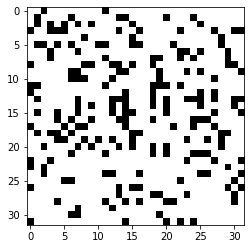

In [68]:
label = 0
temp = train_data.classes[label]
print(temp)
img = generate_image(G, DEVICE, n_noise, 0)
# print(img.shape)
# print(img)
plt.imshow(img, cmap='gray')

3.2


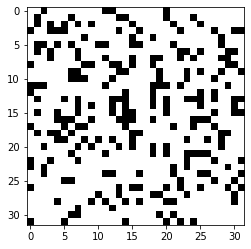

In [69]:

label = 20
temp = train_data.classes[label]
print(temp)
img = generate_image(G, DEVICE, n_noise, 15)
plt.imshow(img, cmap='gray')

In [63]:
# save model
torch.save(G, MODEL_PATH+'G.pth')